# 线性回归

### 矢量化加速
在训练模型时，常希望能同时处理整个小批次样本，为此需要对计算进行**矢量化**，从而利用线性代数库

In [81]:
import math
import time
import numpy as py
import torch

from d2l import torch as d2l

说明矢量化的重要性

In [83]:
n = 10000
a = torch.ones([n])
b = torch.ones([n])

定义**计时器**

In [ ]:
class Timer:
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        self.tik = time.time()

    def stop(self):
        """
        停止计时器并将时间记录在列表中
        """
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        return sum(self.times) / len(self.times)

    def cumsum(self):
        return np.array(self.times).cumsum().tolist()

## 线性回归的从0开始实现

In [8]:
%matplotlib inline

import random
import torch
import matplotlib.pyplot as plt

from d2l import torch as d2l

### 根据带有噪声的线性模型构造一个人造数据集
- `torch.randn()`只能生成标准正态分布的随机张量
- `torch.normal()`可以指定均值和标准差
- `torch.matmul()`可以根据输入的张量维度自动调整乘法操作，从而适用于各种矩阵和张量运算场景
- `torch.dot()`只适用于 一维张量（向量），用于计算两个向量的点积，返回一个标量

In [59]:
def synthetic_data(w, b, num_examples):
    """
    生成 y = Xw + b + 噪声
    """
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape(-1, 1)

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
labels.shape

torch.Size([1000, 1])

In [60]:
print(features[0], labels[0])

tensor([-0.5118, -0.0826]) tensor([3.4600])


通过生成第二个特征`features[:, 1]`和`labels`的散点图，
可以直观观察到两者之间的线性关系

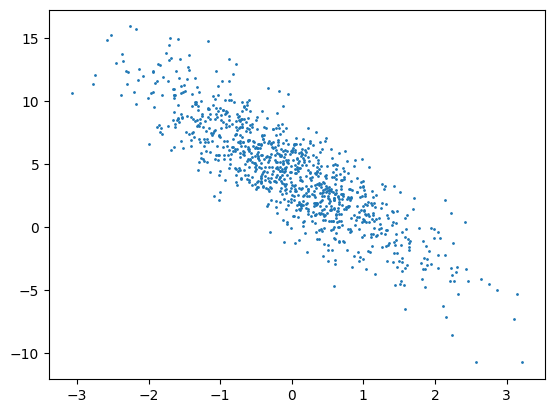

In [61]:
plt.scatter(features[:, 1], labels, 1)
# d2l.plt.scatter(features[:, 1].detach().numpy(),
#                 labels.detach().numpy(), 1)

### 读取数据

#### 生成大小为`batch_size`的小批量
- 将数据**打乱**后，按批次迭代
- `batch_indices`要转为**tensor**

In [62]:
def data_iter(batch_size, features, labels):
    num_examples = features.shape[0]
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 1.9292,  0.5492],
        [ 0.7879,  0.8052],
        [ 0.5822, -1.6385],
        [-1.0286, -0.3063],
        [-0.3334, -0.0070],
        [-0.2908, -0.8141],
        [-0.6285, -0.4960],
        [ 0.6728,  1.1563],
        [ 0.1840,  1.0856],
        [-1.5294,  0.4261]]) 
 tensor([[ 6.1834],
        [ 3.0278],
        [10.9325],
        [ 3.1864],
        [ 3.5506],
        [ 6.3882],
        [ 4.6269],
        [ 1.6169],
        [ 0.8749],
        [-0.3116]])


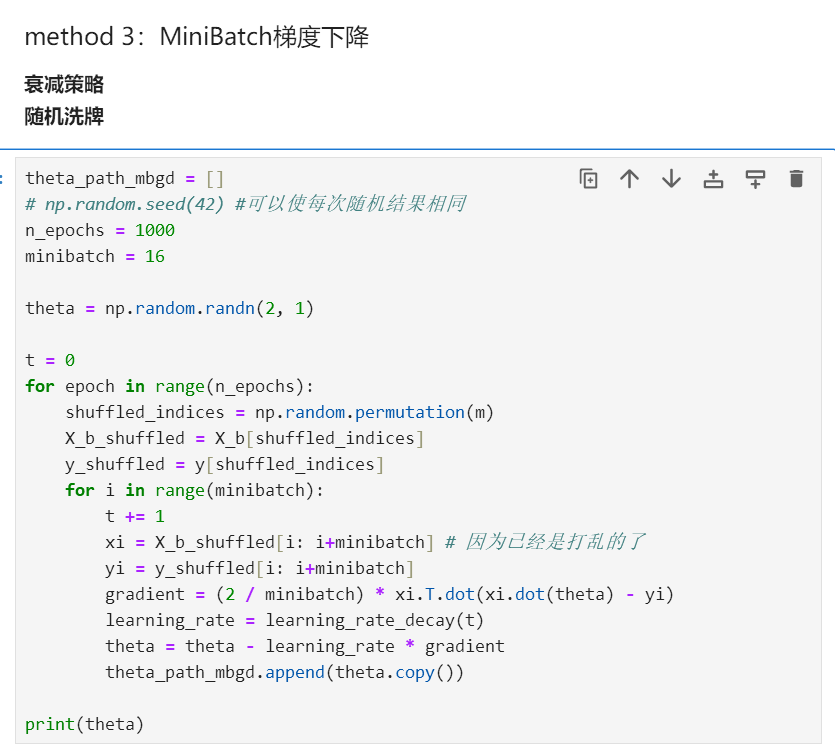

### 定义初始化模型参数 
需要**计算**损失函数关于模型参数的梯度
- torch.zeros(size=())——0维张量
- torch.zeros(1)——1维张量，包含一个元素

In [63]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

### 定义模型

In [64]:
def lin_reg(X, w, b):
    # 线性回归模型
    return torch.matmul(X, w) + b

### 定义损失函数

In [65]:
def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

### 定义**优化算法**：小批量梯度下降

In [66]:
def sgd(params, lr, batch_size):
    with torch.no_grad(): # 不用计算梯度
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

### 训练过程
执行以下循环：
- 计算梯度$\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$
- 更新参数$(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$  

在每个epoch中，使用`data_iter`函数遍历整个数据集，并将训练集中所有样本都使用一次

In [67]:
lr = 0.03
num_epochs = 3
net = lin_reg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)
        l.sum().backward()
        sgd([w, b], lr, batch_size) # 参数更新（最后一个可能不是正好，这里是）
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels) # 对整个训练集进行一次求loss
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.030483
epoch 2, loss 0.000104
epoch 3, loss 0.000048


In [70]:
print(f'w的误差：{true_w - w.reshape(true_w.shape)}')
print(f'b的误差：{true_b - b}')

w的误差：tensor([ 6.1870e-05, -6.3682e-04], grad_fn=<SubBackward0>)
b的误差：tensor([0.0001], grad_fn=<RsubBackward1>)


### 小结

* 我们学习了深度网络是如何实现和优化的。在这一过程中只使用**张量**和**自动微分**，不需要定义层或复杂的优化器。
* 这一节只触及到了表面知识。在下面的部分中，我们将基于刚刚介绍的概念描述其他模型，并学习如何更简洁地实现其他模型。

### 练习

1. 如果我们将权重初始化为零，会发生什么。算法仍然有效吗？
1. 假设试图为电压和电流的关系建立一个模型。自动微分可以用来学习模型的参数吗?
1. 能基于[普朗克定律](https://en.wikipedia.org/wiki/Planck%27s_law)使用光谱能量密度来确定物体的温度吗？
1. 计算二阶导数时可能会遇到什么问题？这些问题可以如何解决？
1. 为什么在`squared_loss`函数中需要使用`reshape`函数？
1. 尝试使用不同的学习率，观察损失函数值下降的快慢。
1. 如果样本个数不能被批量大小整除，`data_iter`函数的行为会有什么变化？

### 回答
1. 若所有权重初始化为0，则所有神经元的输出都相同，则不论输入时什么，都会导致梯度相同，导致网络在训练时无法有效更新权重
- 输入相同的权重，会导致**对称性问题**
2. 自动微分是一种计算梯度的工具，适用于所有可以表示为数学函数的模型。只要模型的输入和输出可以**通过数学函数关联起来**，自动微分就可以学习模型的参数
4. 计算复杂度高（Hessian矩阵）  
数值不稳定  
非凸性问题  
内存消耗大
5. 解决办法：使用**学习率调度器**或**自适应优化算法**
6. 会产生最后一个批次，样本数量小于设定的批次大小  
在使用`DataLoader`时，为避免可以使用`DataLoader(dataset, batch_size= , drop_last=True)`

### 补充
- 神经网络中，权重初始化对网络的训练速度和性能起着关键作用，如果权重初始化不当，可能导致训练过程中的梯度消失或梯度爆炸问题
- **Xavier初始化**：将权重初始化为如下情况 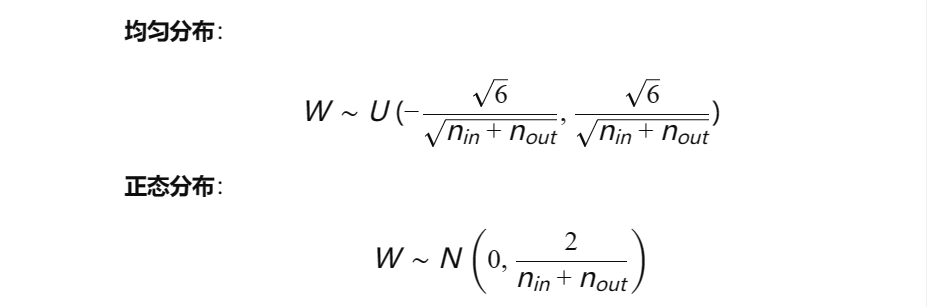 适用于Sigmoid、Tanh等对称函数，有时会面临梯度消失问题
- **He初始化**：适用于ReLU或其变体激活函数，在负值区域会输出0，会将权重初始化为如下情况 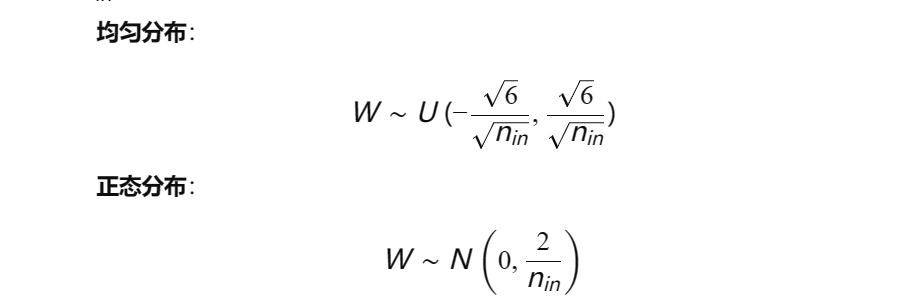
- 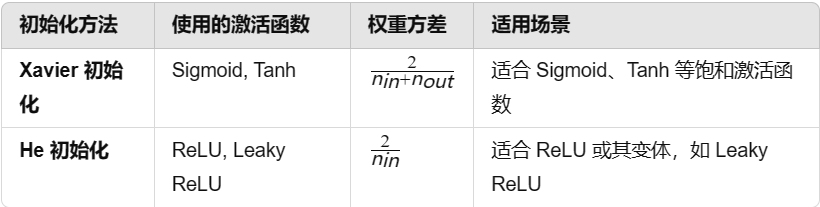

## 线性回归的简洁实现
通过使用**深度学习框架**来简洁地实现线性回归模型

In [72]:
import numpy as np
import torch

from torch.utils import data
from d2l import torch as d2l

In [73]:
true_w = torch.tensor([2, -3.4])
ture_b = 4.2
num_examples = 1000
features, labels = d2l.synthetic_data(true_w, true_b, num_examples)

### 调用框架中现有的API来读取数据
- `data.TensorDataset`
- `data.DataLoader`
- `iter()`
- `next()`

In [74]:
def load_array(data_arrays, batch_size, is_train=True):
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

next(iter(data_iter))


[tensor([[-0.3875, -0.3258],
         [ 0.9782, -0.6059],
         [ 0.3694, -0.5956],
         [-0.3087, -1.1926],
         [-1.3119,  2.4035],
         [-0.9200,  0.1257],
         [-0.1089, -0.4019],
         [-0.3624, -1.9586],
         [ 0.0740, -1.6527],
         [ 1.3544, -1.4867]]),
 tensor([[ 4.5457],
         [ 8.2096],
         [ 6.9645],
         [ 7.6379],
         [-6.5931],
         [ 1.9273],
         [ 5.3256],
         [10.1350],
         [ 9.9563],
         [11.9714]])]

### 定义模型

#### 对于标准深度学习模型，我们可以[**使用框架的预定义好的层**]。
- 只需关注使用哪些层来构造模型，而不必关注层的实现细节。  
- 我们首先定义一个模型变量`net`，它是一个`Sequential`类的实例。  
- `Sequential`类将多个层串联在一起。当给定输入数据时，`Sequential`实例将数据传入到第一层，然后将第一层的输出作为第二层的输入，以此类推。  
- 在下面的例子中，我们的模型只包含一个层，因此实际上不需要`Sequential`。  
- 单层网络架构，这一单层被称为*全连接层*（fully-connected layer），每一个输入都通过矩阵-向量乘法得到它的每个输出

In [75]:
from torch import nn

net = nn.Sequential(nn.Linear(2, 1))

#### **初始化模型参数**
使用net前要初始化模型参数
- 指定每个weight参数从σ(0,0.01)的正态分布中随机采样，偏置参数初始化为0
- 通过`net[0]`选择网络中的第一个图层
- 使用`weight.data`和`bias.data`方法访问参数
- 使用替换方法`normal_`和`fill_`来重写参数值

In [76]:
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

### 定义损失函数
**计算均方误差使用的是`MSELoss`类，也称为平方$L_2$范数**

In [77]:
loss = nn.MSELoss()

### 定义优化算法
- **小批次随机梯度下降**，在`optim`模块中SGD
- 指定优化的参数
（可通过`net.parameters()`从模型中获得）以及优化算法所需的超参数字典
- 小批量随机梯度下降只需要设置`lr`值

In [78]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

### 训练
对于每一个小批量，会进行以下步骤：
- 通过调用`net(X)`生成预测并计算损失`l`（向前传播）
- 通过进行反向传播来计算梯度
- 通过调用优化器来更新模型参数
为了更好衡量训练效果，计算每个迭代周期后的损失

代码
- `trainer.zero_grad()`
- `trainer.step()`

In [79]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:  # 遍历数据集的每一批次
        l = loss(net(X), y)   # 向前传播：计算损失   # net自带参数
        trainer.zero_grad()   # 先梯度清零，避免累积上次的梯度
        l.backward()          # 反向传播：计算当前批次的梯度    # 已经sum过了
        trainer.step()        # 用step来进行模型更新
    l = loss(net(features), labels) # 每轮训练后计算整体损失
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000214
epoch 2, loss 0.000105
epoch 3, loss 0.000103


In [80]:
w = net[0].weight.data
print('w的误差估计', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的误差估计', true_b - b)

w的误差估计 tensor([0.0005, 0.0004])
b的误差估计 tensor([1.3828e-05])


### 小结
* 我们可以使用PyTorch的高级API更简洁地实现模型。
* 在PyTorch中，`data`模块提供了数据处理工具，`nn`模块定义了大量的神经网络层和常见损失函数。
* 我们可以通过`_`结尾的方法将参数替换，从而初始化参数。

### 练习
1. 如果将小批量的总损失替换为小批量损失的平均值，需要如何更改学习率？
1. 查看深度学习框架文档，它们提供了哪些损失函数和初始化方法？用Huber损失代替原损失，即
    $$l(y,y') = \begin{cases}|y-y'| -\frac{\sigma}{2} & \text{ if } |y-y'| > \sigma \\ \frac{1}{2 \sigma} (y-y')^2 & \text{ 其它情况}\end{cases}$$
1. 如何访问线性回归的梯度？

### 回答
1. 总损失变为平均损失，则梯度会变小  
为补偿梯度的缩小，学习率要增大
2.  Huber损失是一种平滑的损失函数，结合了L1和L2损失的优点  
误差较小，用L2损失（平方误差）  
误差较大，用L1损失（绝对误差）  
- 常用的损失函数如下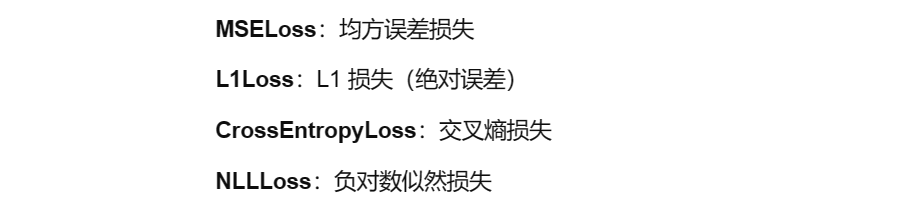